In [31]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('ggplot')

In [32]:
data_excel = 'Data Set.xlsx'
cred = pd.read_excel(data_excel)

In [33]:
# Selecting features based on their correlation with target variables
feat = [
        'card',
        'card2',
        'age',
        'income',
        'lninc',
        'inccat',
        'debtinc',
        'lncreddebt',
        'othdebt',
        'lnothdebt',
        'default',
        'carcatvalue',
        'cardtype',
        'card2type',
        'active',
        'cardspent',
        'card2spent']

cred = cred[feat]

In [34]:
cred

,card,card2,age,income,lninc,inccat,debtinc,lncreddebt,othdebt,lnothdebt,default,carcatvalue,cardtype,card2type,active,cardspent,card2spent
0,3,5,20,31,3.433987,2,11.1,0.183079,2.240091,0.806516,1,1,1,3,0,81.66,67.80
1,2,4,22,15,2.708050,1,18.6,0.200505,1.567980,0.449788,1,1,4,1,1,42.60,34.94
2,2,4,67,35,3.555348,2,9.9,-0.074056,2.536380,0.930738,0,1,1,1,0,184.22,175.75
3,2,3,23,20,2.995732,1,5.7,-3.780995,1.117200,0.110826,1,1,1,2,1,340.99,18.42
4,4,1,26,23,3.135494,1,1.7,-1.538705,0.176341,-1.735336,0,1,2,3,1,255.10,252.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,3,68,196,5.278115,5,8.0,2.071167,7.745920,2.047166,0,3,3,3,0,872.11,553.56
4996,3,5,51,83,4.418841,4,15.0,1.204952,9.113400,2.209746,1,3,4,1,1,210.81,155.54
4997,1,2,75,108,4.682131,4,10.8,1.269064,8.106480,2.092664,0,3,3,4,0,884.08,643.67
4998,3,4,47,189,5.241747,5,10.8,1.613699,15.390648,2.733760,1,3,1,3,0,381.35,371.60


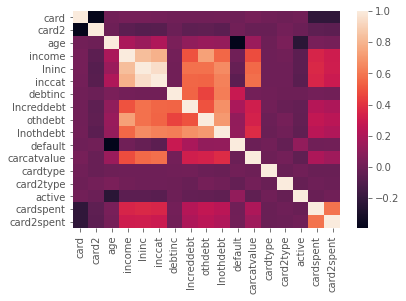

In [4]:
sns.heatmap(cred.corr())
plt.show()

In [5]:
# deviding data into continuous and categorical to process separately
cat_data = cred[['active','card2type','cardtype','default','inccat','card', 'card2']]
cont_data = cred[cred.columns.difference(cat_data.columns.to_list()+['cardspent','card2spent'])]

In [6]:
# outliers and missing value treatment
cont_data = cont_data.apply(lambda x : x.clip(upper=x.quantile(0.99), lower=x.quantile(0.01)))
cont_data = cont_data.apply(lambda x : x.fillna(x.mean()))

In [7]:
# creating dummies of categorical var
cat_data = pd.get_dummies(cat_data.astype('object'),drop_first=True)

In [8]:
# creating new dataframe after processing data
new_cred = pd.concat([cont_data,cat_data],axis=1)
new_cred['cardspent'] = cred['cardspent'] + cred['card2spent']
new_cred['ln_cardspent'] = np.log(new_cred['cardspent'])

In [9]:
# feature selection using f_regression and vif
f_reg_df = pd.DataFrame()
f_reg = f_regression(new_cred[new_cred.columns.difference(['cardspent','ln_cardspent'])],new_cred['ln_cardspent'])
f_reg_df["Columns"] = new_cred.columns.difference(['cardspent','ln_cardspent'])
f_reg_df["Stats"] = f_reg[0]
f_reg_df["P_value"] = f_reg[1]
f_reg_df.sort_values("P_value").head()

,Columns,Stats,P_value
25,lninc,964.559533,8.571730e-194
23,income,710.605426,1.689120e-146
26,lnothdebt,399.416895,1.499438e-85
27,othdebt,357.160372,5.353901e-77
24,lncreddebt,336.255859,9.676994e-73


In [10]:
vif = pd.DataFrame()
vif["columns"] = new_cred.columns
vif["vif"] = [variance_inflation_factor(new_cred.values,i) for i in range(new_cred.shape[1])]
vif.head()

,columns,vif
0,age,10.643176
1,carcatvalue,4.122929
2,debtinc,18.101407
3,income,40.212744
4,lncreddebt,2.939712


In [11]:
# removing features based on information gained from f_regression and vif
_new_cred = new_cred.drop([
    'income','inccat_2',
    'inccat_3','inccat_4',
    'inccat_5','active_1',
    'card2type_2','card2type_3',
    'cardtype_3','cardtype_4',
    'lnothdebt','default_1'],axis=1)

In [12]:
# dividing data into test and train 
train, test = train_test_split(_new_cred, test_size=0.3, random_state=1234)
train = train.drop(['cardspent'],axis=1)
test = test.drop(['cardspent'],axis=1)

In [13]:
# stats model
formula = 'ln_cardspent ~ ' + ' + '.join(_new_cred.columns.difference(['ln_cardspent','cardspent'])) 
lm = smf.ols(formula,train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_cardspent   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     105.5
Date:                Mon, 09 Nov 2020   Prob (F-statistic):          6.65e-284
Time:                        11:17:10   Log-Likelihood:                -2933.5
No. Observations:                3500   AIC:                             5901.
Df Residuals:                    3483   BIC:                             6006.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5936      0.117     47.867      

In [14]:
# lm summary:
#___________________________________________
# R-squared:           |            0.326
# Adj. R-squared:      |            0.323
#______________________|____________________

# R-squared should be as large as possible but not so that the model is overfitted
# Adj. R-squared should be as close to R-squared as possible 

In [15]:
# dropping influential datapoints to increase the accuracy of the model
train.drop(np.abs(lm.resid).sort_values()[-400:].index,inplace=True)

In [16]:
lm = smf.ols(formula,train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_cardspent   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     148.8
Date:                Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:17:10   Log-Likelihood:                -1540.6
No. Observations:                3100   AIC:                             3115.
Df Residuals:                    3083   BIC:                             3218.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.7374      0.089     64.813      

In [17]:
# lm summary:
#___________________________________________
# R-squared:           |            0.436
# Adj. R-squared:      |            0.433
#______________________|____________________

In [18]:
# root_mean_squared_error (for train)
np.sqrt(mean_squared_error(np.exp(train['ln_cardspent']),np.exp(lm.predict(train)))) 
# 211.8670606338464

211.867060633849

In [19]:
# root_mean_squared_error (for train)
np.sqrt(mean_squared_error(np.exp(test['ln_cardspent']),np.exp(lm.predict(test)))) 
# 283.83144183796105

283.83144183796355

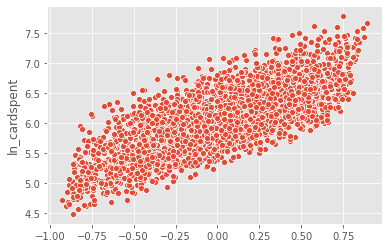

In [24]:
# No Heteroscedasticity
# No Auto Correlation
# Assumption satisfied
sns.scatterplot(lm.resid, train.ln_cardspent)
plt.show()